In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
pio.renderers.default = "iframe_connected"

In [2]:
shops = pd.read_csv('shops.csv')

In [3]:
shops.head()

,SHOP_ID,COACH,ZIPCODE,CITY,COUNTRY,OPENING_TIME,CLOSING_TIME,IS_CANCELLED,CANCELLED_AT,AUTOMATIC_PLANNING_USES,...,MEAL_COMPENSATION_ACTIVATED,SEND_REPORT_BY_EMAIL,DAY_BADGING_ACTIVATED,CONFIGURED,BADGING,AUTOMATIC_PLANNING_ACTIVE,INTEGRATIONS,LATITUDE,LONGITUDE,CREATED_AT
0,1743,marie-victoire@skello.io,35740,PACE,FR,2018-07-30 09:00:00.000000000,2018-07-30 00:00:00.000000000,True,2021-10-30 00:00:00.000000000,0,...,True,False,False,True,False,False,NaN,48.140920,-1.767448,2018-07-31 14:29:23.371493000
1,7623,marie-victoire@skello.io,73700,Bourg Saint Maurice,FR,2021-08-01 00:00:00.000000000,2021-08-01 00:00:00.000000000,True,2021-10-27 00:00:00.000000000,0,...,True,False,False,True,False,False,NaN,45.591389,6.769210,2020-10-26 10:01:48.877575000
2,4763,meng-lan@skello.io,71570,CHAINTRE,FR,2021-07-20 00:00:00.000000000,2021-07-20 00:00:00.000000000,True,2021-11-15 00:00:00.000000000,0,...,True,False,False,True,False,False,bhi,46.256817,4.791242,2019-12-05 14:21:31.775364000
3,8284,hello@skello.io,97434,LA SALINE LES BAINS,FR,2022-01-04 00:00:00.000000000,2022-01-04 00:00:00.000000000,True,2022-01-24 00:00:00.000000000,0,...,True,False,False,True,False,False,NaN,-21.099753,55.242180,2021-01-18 08:18:07.043409000
4,2054,constance@skello.io,45100,ORLEANS LA SOURCE,FR,2020-08-27 05:00:00.000000000,2020-08-27 05:00:00.000000000,True,2021-07-12 00:00:00.000000000,0,...,True,False,False,True,False,False,spv,47.814633,1.929799,2018-10-08 12:51:42.495907000


In [4]:
#Write all cities in uppercase 
shops['CITY'] = shops['CITY'].str.upper()

### General Analysis on all shops

In [5]:
#Where are the users? 
fig = px.scatter_mapbox(shops, lat="LATITUDE", lon="LONGITUDE",  color='IS_CANCELLED', zoom = 4,
                        mapbox_style="open-street-map", hover_name = 'CITY', color_continuous_scale = 'Plasma', title='User geographical repartition in France') #,
                       
fig.show()

In [6]:
#How much churn do we have for Paris?
shopschurn = round(sum(shops['IS_CANCELLED'] == True) / len(shops) * 100)
print('About {}% of all time users have churned.'.format(shopschurn))

About 86% of all time users have churned.


In [7]:
#Where are concentrated our users?
shops['CITY'].value_counts()

PARIS                    121
STRASBOURG                32
LYON                      21
MAMOUDZOU                 20
BORDEAUX                  17
                        ... 
TORCY                      1
MAMOUDZOU                  1
DIGNE LES BAINS            1
LA CHAPELLE SAINT LUC      1
DOUVAINE                   1
Name: CITY, Length: 536, dtype: int64

In [8]:
#Paris represents 12% of our users
parisrep = round(sum(shops['CITY'] == 'PARIS') / len(shops) * 100)
print('Paris represents {}% of all users.'.format(parisrep))

Paris represents 12% of all users.


In [9]:
#Isolating Parisian users
paris = shops.loc[shops['CITY'] == 'PARIS']

In [10]:
#How much churn do we have for Paris?
parischurn = round(sum(paris['IS_CANCELLED'] == True) / len(paris) * 100)
print('About {}% of Parisian users have churned.'.format(parischurn))

About 80% of Parisian users have churned.


In [11]:
#Focus on Parisian users
fig = px.scatter_mapbox(paris, lat="LATITUDE", lon="LONGITUDE",  color='IS_CANCELLED', zoom = 11,
                        mapbox_style="open-street-map", hover_name = 'CITY', color_continuous_scale = 'Plasma', title='Parisian users') #,
                       
fig.show()

**In this dataset, there are only 138 out of 978 that have not churned (14%):**

In [12]:
shops['IS_CANCELLED'].value_counts()

True     842
False    138
Name: IS_CANCELLED, dtype: int64

In [13]:
px.pie(shops, names='IS_CANCELLED', title='Churned vs Not Churned')

In [14]:
#Transform date columns to datetime format to allow calculations
shops['CREATED_AT'] = pd.to_datetime(shops['CREATED_AT'])
shops['CANCELLED_AT'] = pd.to_datetime(shops['CANCELLED_AT'])

In [15]:
#Create a DaysActive column to have the usage duration for shops that have churned
shops['DaysActive'] = ""

In [16]:
#Filling the column
for i in range(len(shops)):
    shops['DaysActive'][i] = (shops['CREATED_AT'][i] - shops['CANCELLED_AT'][i]).days

/tmp/ipykernel_132/614484659.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
#Looking for absurd values (created date is after churn date)
for i in range(len(shops)):
    if shops['CREATED_AT'][i] > shops['CANCELLED_AT'][i]:
        print(i)

564


In [18]:
#drop row with absurd value
shops = shops.drop(shops.index[564])

### **Product Usage Analysis**

In [19]:
#Separating churned vs not churned to identify differences in product usage & parameters
churned = shops[shops['IS_CANCELLED'] == True]
notchurned = shops[shops['IS_CANCELLED'] == False]

**Usage of the "Smart Planner" feature:**

In [20]:
#Smart Planner feature usage
actplan = round(sum(notchurned['AUTOMATIC_PLANNING_ACTIVE'] == True) / len(notchurned) * 100)
chuplan = round(sum(churned['AUTOMATIC_PLANNING_ACTIVE'] == True) / len(churned) * 100)
print('{}% of active users and {}% of churned users were using the Smart Planner.'.format(actplan, chuplan))

0% of active users and 0% of churned users were using the Smart Planner.


In [21]:
#Indeed, only 3 shops have the Smart Planner activated
shops.groupby('AUTOMATIC_PLANNING_ACTIVE')[['SHOP_ID']].count()

,SHOP_ID
AUTOMATIC_PLANNING_ACTIVE,
False,976
True,3


**Usage of "Meal Compensation" feature:**

In [22]:
#Meal Compensation feature usage
actmeal = round(sum(notchurned['MEAL_COMPENSATION_ACTIVATED'] == True) / len(notchurned) * 100)
chumeal = round(sum(churned['MEAL_COMPENSATION_ACTIVATED'] == True) / len(churned) * 100)
print('{}% of active users and {}% of churned users were using the Meal Compensation feature.'.format(actmeal, chumeal))

61% of active users and 52% of churned users were using the Meal Compensation feature.


**"Optimisation Activated By Hand" feature:**

In [23]:
#Optimisation Activated by Hand feature usage
actopt = round(sum(notchurned['OPTIMISATION_ACTIVATED_BY_HAND'] == True) / len(notchurned) * 100)
chuopt = round(sum(churned['OPTIMISATION_ACTIVATED_BY_HAND'] == True) / len(churned) * 100)
print('{}% of active users and {}% of churned users had the Optimisation Activated by Hand active.'.format(actopt, chuopt))

46% of active users and 40% of churned users had the Optimisation Activated by Hand active.


**"Send Report by Email" feature:**

In [24]:
#Active users
actreport = round(sum(notchurned['SEND_REPORT_BY_EMAIL'] == True) / len(notchurned) * 100)
chureport = round(sum(churned['SEND_REPORT_BY_EMAIL'] == True) / len(churned) * 100)
print('{}% of active users and {}% of churned users were using the Send Report by Email feature.'.format(actreport, chureport))

0% of active users and 0% of churned users were using the Send Report by Email feature.


**All shops had "Configured" as true, which does not give any insight:**

In [25]:
shops.groupby('CONFIGURED')[['SHOP_ID']].count()

,SHOP_ID
CONFIGURED,
True,979


**"Time Clock" feature usage:**

In [26]:
#Badging feature usage
actclock = round(sum(notchurned['BADGING'] == True) / len(notchurned) * 100)
chuclock = round(sum(churned['BADGING'] == True) / len(churned) * 100)
print('{}% of active users and {}% of churned users were using the Time Clock/Badging feature.'.format(actclock, chuclock))

54% of active users and 43% of churned users were using the Time Clock/Badging feature.


**Integrations: does the product being able to integrate with other tools have an impact?**

In [27]:
#Active users
actint = round(sum(notchurned['INTEGRATIONS'].notnull()) / len(notchurned) * 100)
chuint = round(sum(churned['INTEGRATIONS'].notnull()) / len(churned) * 100)
print('{}% of active users and {}% of churned users had integrated the product with other tools.'.format(actint, chuint))

20% of active users and 22% of churned users had integrated the product with other tools.


## Let's take a closer look at users that churned:

The 'lost_mrr' dataset gives us more in depth informations. It was merged with the 'shops' dataset on 'SHOP_ID'.

In [28]:
df = pd.read_csv('merged_mrr.csv')

In [29]:
df['CLOSE_DATE'] = pd.to_datetime(df['CLOSE_DATE'])
df['LOST_DATE'] = pd.to_datetime(df['LOST_DATE'])

In [30]:
#Adding the DaysActive column
df['DaysActive'] = ""
for i in range(len(df)):
    df['DaysActive'][i] = (df['CLOSE_DATE'][i] - df['LOST_DATE'][i]).days

/tmp/ipykernel_132/3191168377.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### General Analysis

In [31]:
fig = px.pie(df, names=df['MACRO_INDUSTRY'])
fig.show()

In [32]:
px.pie(df, names='AUTOMATIC_PLANNING_ACTIVE', title='Usage of Smart Planner')

Half of the shops that churned had a change in their contract:

In [33]:
#What's the distribution of opportunity types?
fig = px.histogram(df, x="MACRO_INDUSTRY", title="Repartition of Opportunity Types amongst Industries", color= df['OPPORTUNITY_TYPE'])
fig.show()

The majority of shops that churned in the Hospitality industry had a change in their contract.

**A few questions come up at this point:**
- Is the product a good fit for the Hospitality industry? What needs were not adressed by the product?
- What kind of changes were made to the contracts? 
- Were some functionalities deactivated or added? 
- Was the smart planner activated on previous contracts?
- Is the "close date" the first day of the new contract, or the first every contract signed? 

The second type of opportunity that churned were New Businesses. 

In [34]:
#How much potential MRR for Hospitality?
hosp = df.loc[df['MACRO_INDUSTRY'] == 'Hospitality']
mrrhosp = round(hosp['LOST_MRR'].mean())
nbhosp = len(hosp)
calc = mrrhosp * nbhosp
print('The hospitality potential MRR is {}€ * {} = {}€ for the period.'.format(mrrhosp, nbhosp, calc))

The hospitality potential MRR is 114€ * 627 = 71478€ for the period.


In [35]:
#How much potential for MRR for Retail?
retail = df.loc[df['MACRO_INDUSTRY'] == 'Retail']
mrrretail = round(retail['LOST_MRR'].mean())
nbretail = len(retail)
calcu = mrrretail * nbretail
print('The retail potential MRR is {}€ * {} = {}€ for the period.'.format(mrrretail, nbretail, calcu))

The retail potential MRR is 116€ * 204 = 23664€ for the period.


### Time Analysis

The churn repartition between industries overtime doesn't seem to change drastically : Hospitality and Retail are always churning the most. 

Unfortunately, we don't have enough data to be able to observe true seasonal patterns.

Although, we can identify a spike in Hospitality churn in January 2022:
- Can it be linked to budgets being reduced, as it often happens at the beginning of the year?
- Was a feature taken out in 2022, that was critical for Hospitality?

In [36]:
#Creating a column with month&year
df['ym-date'] = df['LOST_DATE'].dt.strftime('%Y-%m')

In [37]:
fig = px.histogram(x=df["ym-date"], color=df['MACRO_INDUSTRY'])
fig.show()

Hospitality follows the same pattern as the other industries:

<AxesSubplot:xlabel='ym-date'>

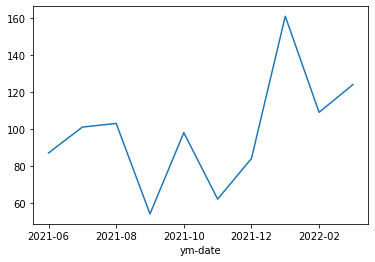

In [38]:
df.groupby(df['ym-date']).size().plot()

In [39]:
#Isolating Hospitality
hosp = df.loc[df['MACRO_INDUSTRY'] == 'Hospitality']

<AxesSubplot:xlabel='ym-date'>

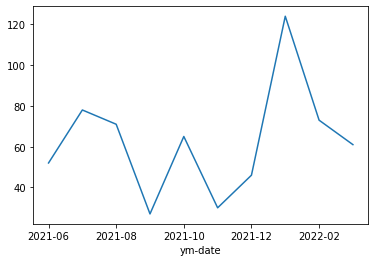

In [40]:
hosp.groupby(hosp['ym-date']).size().plot()

### Customer Journey and Experience

A customer’s journey and experience is extremely tight to his interactions with the company (here, whoever was in charge of onboarding the user). 


In [41]:
#Number of accounts (over 50) per coach that churned for the period
display(df['COACH'].value_counts().head(7))

hello@skello.io               163
timothee@skello.io            107
maelle.briot@skello.io         91
agathe.lemaistre@skello.io     81
constance@skello.io            70
marie-victoire@skello.io       63
ilona.dronne@skello.io         55
Name: COACH, dtype: int64

There are 163 accounts that churned that were coached by someone behind the "hello@skello.io" email adress, which is impossible to track.

In [42]:
#Isolating the first seven coaches
list_mrr = ['hello@skello.io','timothee@skello.io','maelle.briot@skello.io','agathe.lemaistre@skello.io','constance@skello.io','marie-victoire@skello.io','ilona.dronne@skello.io']

In [43]:
#Create a df with only the 7 coaches with the most lost MRR
df2 = df[df['COACH'].isin(list_mrr)]

In [44]:
#Average and sum of lost MRR per coach
df2.groupby('COACH').agg({'LOST_MRR': ['mean', 'sum']})

LOST_MRR          
                                  mean       sum
COACH                                           
agathe.lemaistre@skello.io  127.084691  10293.86
constance@skello.io          84.257143   5898.00
hello@skello.io             125.618712  20475.85
ilona.dronne@skello.io      122.035818   6711.97
maelle.briot@skello.io      115.392857  10500.75
marie-victoire@skello.io    101.985714   6425.10
timothee@skello.io           71.505421   7651.08

**Coaches don't seem to be specialized in some industries:**

In [45]:
#Industries amongst coaches
fig = px.histogram(x=df2["COACH"], color=df2['MACRO_INDUSTRY'])
fig.show()

In [46]:
#Acquisition channels per coach
fig = px.histogram(x=df2["COACH"], color=df2['CANAL'])
fig.show()

In [47]:
px.pie(df, names='CANAL', title='Canal repartition')

It appears that leads from inbound marketing strategies are more qualitative and less prone to churn than leads from outbound marketing strategies.

In [48]:
inbound = df2.loc[df2['CANAL'] == 'Inbound']
outbound = df2.loc[df2['CANAL'] == 'Outbound']

In [49]:
inboundact = inbound['DaysActive'].mean()
outboundact = outbound['DaysActive'].mean()
print('Churned users coming from Inbound used the product for an average of {} days, and {} days for churned users from Outbound.'.format(inboundact, outboundact))

Churned users coming from Inbound used the product for an average of -285.5112781954887 days, and -207.86206896551724 days for churned users from Outbound.


**What are the 5 most sold memberships?**

In [50]:
df['LOST_MRR'].value_counts().head(5)

109.0    178
139.0    144
188.0     75
89.0      53
125.1     50
Name: LOST_MRR, dtype: int64

In [51]:
#Isolating Success Memberships
memberships = df.loc[df['LOST_MRR'] == 109.0]

**Half of churned users on a Success Membership were new users:**

In [52]:
px.pie(memberships, names='OPPORTUNITY_TYPE', title='Opportunity types for Success Membership')

In [53]:
df2.groupby('COACH')[['TEAM']].value_counts()

COACH                       TEAM              
agathe.lemaistre@skello.io  CSM                   18
                            Outbound               4
                            Account Management     2
constance@skello.io         CSM                   70
hello@skello.io             CSM                   39
                            Inbound               28
                            Outbound              23
                            Account Management    15
                            Self_Serve             1
ilona.dronne@skello.io      CSM                   12
                            Outbound               4
                            Account Management     3
maelle.briot@skello.io      CSM                   30
                            Outbound              19
                            Account Management     4
                            Inbound                3
marie-victoire@skello.io    CSM                   20
                            Inbound               10